# Anomaly Detection 📍

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim"
    }
</style>

In [1]:
%reload_ext autoreload

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import plotly.express as px
import shap
from sklearn.ensemble import IsolationForest

from utils.data_preparation import *

## 1️⃣  Load data

In [2]:
path_train = '../../../01_Data/datasets/selected_species_with_50km_grids.csv'
train_data = pd.read_csv(path_train, index_col=0, low_memory=False).reset_index(drop=True)

In [3]:
# Data we want to predict on
path_validata = '../../../01_Data/datasets/validata_ornitho_ch_2023.csv'
date_format = '%d.%m.%Y'  # ch: '%d.%m.%Y'; de: %m/%d/%Y

# Data we need for data preparation
path_translator_names = '../../../01_Data/translators/translation_species_names_de_vs_ch.csv'
path_eea_grids = '../../../01_Data/eea_gridfiles/eea_europe_grids_50km/inspire_compatible_grid_50km.shp'

# Load and standardize validation data
validata = pd.read_csv(path_validata, delimiter=get_delimiter(path_validata), low_memory=False)
validata = standardize_data(validata, 
                            date_format=date_format,
                            path_translator_species_names=path_translator_names,
                            eea_shapefile_path=path_eea_grids)

In [4]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper'][['date', 'coord_lat', 'coord_lon']]
bergpieper_test = validata[validata.name_species == 'Bergpieper'][['date', 'coord_lat', 'coord_lon']]

In [5]:
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

In [6]:
bergpieper_train.head()

,date,coord_lat,coord_lon
12,1,52.321750,10.432800
30,1,49.144776,10.690435
39,1,51.022837,6.208935
41,1,51.022837,6.208935
44,1,49.872006,12.239931


# 2️⃣ Model V1: Coordinates & Date

In [7]:
model = IsolationForest(contamination='auto', random_state=0)
model.fit(bergpieper_train)

anomalies = model.predict(bergpieper_test)
falsified_data = bergpieper_test[anomalies == -1]  # inliers=1; outliers=-1

In [8]:
print('Number of detected anomalies:', len(falsified_data), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(falsified_data)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 366 / 6431
Percentage of anomalies: 5.69 %


100%|===================| 6399/6431 [00:31<00:00]        

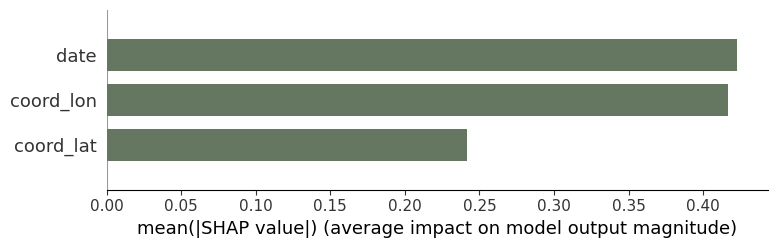

In [52]:
model = IsolationForest(contamination='auto', random_state=0).fit(bergpieper_train)

explainer = shap.Explainer(model, bergpieper_test)
shap_values = explainer.shap_values(bergpieper_test)

shap.summary_plot(shap_values, bergpieper_test, feature_names=['date', 'coord_lat', 'coord_lon'], plot_type='bar', color='#667761')


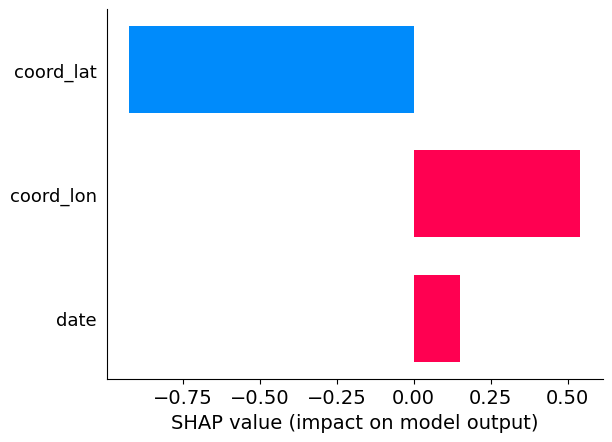

In [55]:
shap.initjs()
shap_values_dp = explainer.shap_values(bergpieper_test.iloc[1])
shap.bar_plot(shap_values_dp, feature_names=bergpieper_test.columns)

In [11]:
feature_names = bergpieper_test.columns
feature_index = np.argmax(np.abs(shap_values[1]))
feature_name = feature_names[feature_index]
print("Feature that contributed most to class -1:", feature_name)

Feature that contributed most to class -1: coord_lat


In [18]:
bergpieper_result = bergpieper_test.copy()
bergpieper_result['error_detected'] = model.predict(bergpieper_test)  # inlier 1 -> 0; outlier -1 -> 1
bergpieper_result['error_detected'] = bergpieper_result.error_detected.replace({1: 0, -1: 1})
bergpieper_result

,date,coord_lat,coord_lon,error_detected
16,191,47.567153,7.551575,0
509,84,46.155468,8.865485,0
510,104,46.162629,8.857722,0
511,77,46.163578,8.855934,0
512,31,46.162629,8.857658,0
...,...,...,...,...
87004,165,46.627150,8.422362,0
87019,101,46.811562,8.914987,0
87029,84,46.393022,7.849465,0
87034,184,46.577266,8.005193,0


In [19]:
feature_names = bergpieper_test.columns
outliers = bergpieper_result[bergpieper_result.error_detected == 1]

error_sources = []

for shaps in shap_values:
    if min(shaps) >=0:
        error_sources.append('None')
    else:
        feature_index = np.argmin(shaps)
        feature_name = feature_names[feature_index]
        error_sources.append(feature_name)

bergpieper_result['most_likely_error_source'] = error_sources
bergpieper_result.loc[bergpieper_result.error_detected == 0, 'most_likely_error_source'] = 'None'

bergpieper_result

,date,coord_lat,coord_lon,error_detected,most_likely_error_source
16,191,47.567153,7.551575,0,None
509,84,46.155468,8.865485,0,None
510,104,46.162629,8.857722,0,None
511,77,46.163578,8.855934,0,None
512,31,46.162629,8.857658,0,None
...,...,...,...,...,...
87004,165,46.627150,8.422362,0,None
87019,101,46.811562,8.914987,0,None
87029,84,46.393022,7.849465,0,None
87034,184,46.577266,8.005193,0,None


In [20]:
bergpieper_result[bergpieper_result.error_detected==1]

,date,coord_lat,coord_lon,error_detected,most_likely_error_source
525,25,46.162629,8.857671,1,date
1564,8,46.171996,8.876071,1,date
1566,1,46.165875,8.871377,1,date
1586,14,46.155402,8.864331,1,date
1590,1,46.171418,8.879824,1,date
...,...,...,...,...,...
86602,187,45.872056,7.166386,1,coord_lat
86654,190,45.935171,7.405672,1,coord_lat
86808,190,45.938193,7.406843,1,coord_lat
86829,190,45.938445,7.405708,1,coord_lat


In [30]:
# Plotly bar plot to show the error sources
import plotly.express as px

fig = px.pie(bergpieper_result, values='error_detected', names='most_likely_error_source', title='Error sources', color_discrete_sequence=['#667761', '#b79492', '#756460'])
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Distribution of most likely error sources", xanchor='center'),
                  legend_title_text='Most Likely Error Source',
                  width=800, height=600)
fig.show()


In [34]:
fig = px.scatter_3d(bergpieper_result, x='date', y='coord_lon', z='coord_lat', color='most_likely_error_source',
                    opacity=0.7, width=800, height=600,
                    labels={'date': 'Date', 'coord_lon': 'Longitude', 'coord_lat': 'Latitude'},
                    title='Outlier Detection',
                    color_discrete_map={'None': '#d9d9d9'})

fig.update_traces(marker={'size': 2})   
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Outlier Detection", xanchor='center'),
                  legend_title_text='Most Likely Error Source')

fig.show()

In [111]:
bergpieper_plot = bergpieper_result.copy()
bergpieper_plot['most_likely_error_source'] = bergpieper_plot.most_likely_error_source.replace(({'None': 'None (not an outlier)', 'coord_lat': 'None (not an outlier)'}))
fig = px.scatter(bergpieper_plot, x='date', y='coord_lon', color='most_likely_error_source',
                 opacity=0.7, width=800, height=300,
                 labels={'date': 'Date', 'coord_lon': 'Longitude'},
                 title='Outlier Detection',
                 color_discrete_map={'None (not an outlier)': '#d9d9d9'})

fig.update_traces(marker={'size': 8})  # Adjust marker size if needed
fig.update_layout(font=dict(family="Aleo", size=12, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, text="Outlier Detection based on date and longitude of sighting", xanchor='center'),
                  legend_title_text='Most Likely Error-Source',
                  margin=dict(t=50, b=10, l=10, r=10), legend=dict(x=0.766, y=0.98))

fig.show()

# 3️⃣ Model V2: Coordinates, Dates & Atlas Codes

In [ ]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper'][['id_species', 'date', 'coord_lat', 'coord_lon', 'atlas_code']]
bergpieper_test = validata[validata.name_species == 'Bergpieper'][['id_species', 'date', 'coord_lat', 'coord_lon', 'atlas_code']]

In [ ]:
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

In [ ]:
bergpieper_train.atlas_code = condense_atlas_codes(bergpieper_train.atlas_code)
bergpieper_test.atlas_code = condense_atlas_codes(bergpieper_test.atlas_code)

In [ ]:
bergpieper_train.head()

,id_species,date,coord_lat,coord_lon,atlas_code
12,469,1,52.321750,10.432800,0
30,469,1,49.144776,10.690435,0
39,469,1,51.022837,6.208935,0
41,469,1,51.022837,6.208935,0
44,469,1,49.872006,12.239931,0


In [ ]:
model = IsolationForest(contamination='auto', random_state=0)
model.fit(bergpieper_train)

anomalies = model.predict(bergpieper_test)
falsified_data_atlas_codes = bergpieper_test[anomalies == -1]  # inliers=1; outliers=-1

In [ ]:
print('Number of detected anomalies:', len(falsified_data_atlas_codes), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(falsified_data_atlas_codes)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 3515 / 6431
Percentage of anomalies: 54.66 %


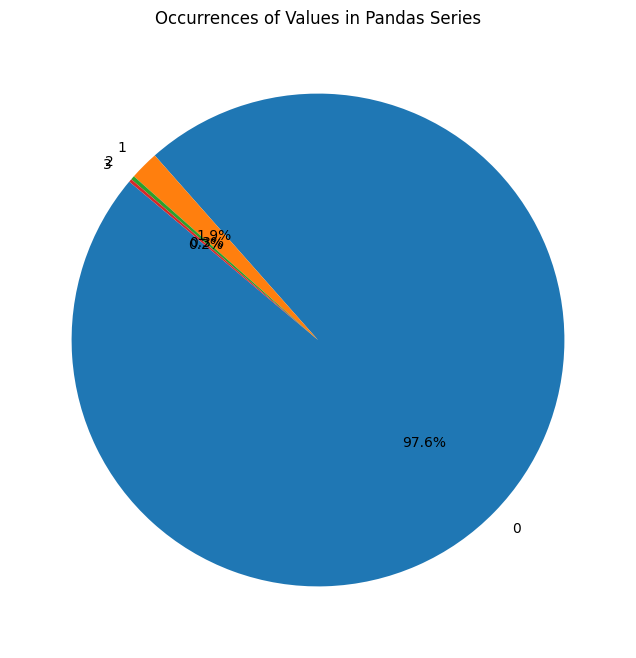

In [ ]:
import matplotlib.pyplot as plt

value_counts = bergpieper_train.atlas_code.value_counts()

# Plot the occurrences as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Occurrences of Values in Pandas Series')
plt.show()